In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
from math import pi

In [2]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

class makedata(Dataset):
    def __init__(self, col, n_feat, maximum):
        self.col = col  # number of datapoints/columns
        self.n_feat = n_feat  # number of features/rows
        self.maximum = maximum   # factor to control the range of feature data
        self.classes = 2   # number of classes

        if col%2 != 0:
            col = col+1
            print("Making total number of datapoints an even number for ease: col =", col)
            
        self.Xdata1 = torch.rand(col//2, n_feat)*maximum +1.5
        self.Xdata2 = torch.rand(col//2, n_feat)*(-maximum) 
        self.Xdata = torch.cat((self.Xdata1, self.Xdata2), dim=0)

        self.Ydata = torch.cat((torch.full((col//2,), 1),torch.full((col//2,), -1)))       

    def __len__(self):
        return len(self.Ydata)

    def __getitem__(self, idx):
        return self.Xdata[idx],self.Ydata[idx]


In [3]:
r =5
col = 100
n_feat = 2
data = makedata(col, n_feat, r)

In [4]:
# print(len(data))
# print(data.Xdata1)
# print(data.Xdata2)
# print(data.Xdata1.shape)
# print(data.Ydata)

In [5]:
# get a certain item from the data
x,y = data.__getitem__(0)
print(x,y)

tensor([1.7810, 2.2433]) tensor(1.)


In [6]:
np_Xdata1 = data.Xdata1.detach().numpy()
np_Xdata2 = data.Xdata2.detach().numpy()

In [7]:
import matplotlib.pyplot as plt

colors = ("red", "blue")
groups = ("class 1", "class 2")

plt.scatter(np_Xdata1[:,0], np_Xdata1[:,1], color="tab:red", label= "Class1")
plt.scatter(np_Xdata2[:,0], np_Xdata2[:,1], color="tab:blue", label = "Class2")
plt.legend(loc = 'best')
plt.show()

<Figure size 640x480 with 1 Axes>

In [8]:
batch_size = 20
data_batches = DataLoader(data, batch_size=batch_size, shuffle=True)
for d in data_batches:
    x,y = d
#     print("new",x,y)
# print(len(y.tolist()))

In [9]:
from pennylane.templates.embeddings import AmplitudeEmbedding

def randomlayer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0,1])

In [10]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev, interface = 'torch')
def circuit(w, p=None):
    AmplitudeEmbedding(p, wires=[0,1], pad=True, normalize=True)
    randomlayer(w[0])
    randomlayer(w[1])
    randomlayer(w[2])
    randomlayer(w[3])
    return qml.expval(qml.PauliZ(0))

In [11]:
def classifier(w, b, p=None):
    return circuit(w, p=p) + b

In [12]:
def get_loss_each(w, b, x, y):
    loss = 0
    loss = loss + (classifier(w, b, p=x) - y)**2    
    return loss 
    
# def check(w, x, y):
#     true_y = y.tolist()
#     pred_y = []
#     for d,l in zip(x,y):
#         res = circuit(w,p=d)
#         if res > 0:
#             pred_y.append(1)
#         else:
#             pred_y.append(-1)
#     diff = [a-b for a,b in zip(true_y, pred_y)]
#     return sum(abs(val) for val in diff)/len(true_y)

def get_loss(w, b, x, y):
    loss = 0
    for d,l in zip(x,y):
        loss = loss + (classifier(w,b, p=d) - l)**2    
    return loss /len(y)

In [13]:
torch.manual_seed(1)
w = Variable(0.01* torch.rand((4,2,3), dtype=torch.float64), requires_grad=True)
b =Variable(0.01 * torch.rand((1,), dtype=torch.float64) , requires_grad=True)
print(w)
print(b)

tensor([[[0.0006, 0.0022, 0.0023],
         [0.0018, 0.0056, 0.0011]],

        [[0.0046, 0.0071, 0.0058],
         [0.0050, 0.0051, 0.0033]],

        [[0.0072, 0.0038, 0.0009],
         [0.0012, 0.0064, 0.0020]],

        [[0.0051, 0.0071, 0.0092],
         [0.0100, 0.0089, 0.0088]]], dtype=torch.float64, requires_grad=True)
tensor([0.0084], dtype=torch.float64, requires_grad=True)


In [14]:
#  for a,b in zip(x,y):
#     print(a)
#     res = circuit(w1_init, w2_init, p = a)
#     pred = [variational_classifier(var, x=x) for x in X]
#     print("pred", res)
#     print("actual", b)    

In [15]:
# print(w1_init.grad)
# loss = get_loss(w1_init, w2_init, x, y)
# print(loss)
# loss.backward()
# print(w1_init.grad)

In [16]:
# # with batches using DataLoader 

# opt = torch.optim.RMSprop([w, b], lr = 0.5)
# rec= []
# for epoch in range(1000):    
#     for d in data_batches:
#         x,y = d
#         opt.zero_grad()
#         loss = get_loss(w, b, x, y)
#         loss.backward()
#         opt.step()
#     rec.append(loss.item())
#     print(loss.item())

In [17]:
# usign the getitem function to get a random datapoint
opt = torch.optim.Adam([w, b], lr = 0.001)
rec= []
for steps in range(3000):    
    r_ind = np.random.randint(low=0, high=100)
    x,y = data.__getitem__(r_ind)
    opt.zero_grad()
    loss = get_loss_each(w, b, x, y)
    loss.backward()
    opt.step()
    rec.append(loss.item())
    if steps%10 ==0:
        print(steps, loss.item())
        print("gradient:", w.grad)


0 4.033253366501647
gradient: tensor([[[ 0.0000e+00, -4.7208e-02,  1.2696e-06],
         [ 1.3764e-06,  3.1897e-04,  1.3624e-06]],

        [[ 1.2696e-06, -6.6792e-02,  4.9250e-06],
         [ 7.9336e-07,  2.0173e-04,  7.8732e-07]],

        [[ 4.9250e-06, -4.6943e-02,  4.1911e-06],
         [-2.1189e-06,  1.6143e-04, -2.1210e-06]],

        [[ 4.1911e-06, -6.6648e-02,  0.0000e+00],
         [-2.2297e-16,  4.4593e-16,  0.0000e+00]]], dtype=torch.float64)
10 3.998358616563753
gradient: tensor([[[ 0.0000e+00, -1.1920e-01, -3.6214e-06],
         [-3.1467e-06,  2.5935e-03, -3.1535e-06]],

        [[-3.6214e-06, -1.4391e-01, -8.5031e-06],
         [-7.0951e-08,  1.3897e-03, -7.0886e-08]],

        [[-8.5031e-06, -1.1938e-01, -7.8205e-06],
         [ 3.9275e-06,  1.2981e-03,  3.9277e-06]],

        [[-7.8205e-06, -1.4393e-01,  0.0000e+00],
         [-4.4400e-16, -2.2200e-16, -6.6600e-16]]], dtype=torch.float64)
20 3.9592022667068982
gradient: tensor([[[ 0.0000e+00, -3.2891e-01,  3.0423e-05],

180 2.9003703701970776
gradient: tensor([[[ 0.0000e+00, -1.6924e+00,  3.8087e-04],
         [ 2.6187e-04,  3.2455e-01,  2.8515e-04]],

        [[ 3.8087e-04, -1.7067e+00,  4.9952e-04],
         [ 5.5556e-05,  1.5522e-01,  6.4086e-05]],

        [[ 4.9952e-04, -1.7579e+00,  3.5793e-04],
         [ 1.5909e-04,  1.5445e-01,  1.6851e-04]],

        [[ 3.5793e-04, -1.7694e+00,  0.0000e+00],
         [ 0.0000e+00,  1.8908e-16,  0.0000e+00]]], dtype=torch.float64)
190 0.10559977610652775
gradient: tensor([[[ 0.0000e+00,  3.6184e-01,  5.6458e-04],
         [ 4.4373e-04,  6.2020e-02,  4.1999e-04]],

        [[ 5.6458e-04,  3.6357e-01,  8.8067e-04],
         [ 4.4622e-04,  3.4142e-02,  4.3378e-04]],

        [[ 8.8067e-04,  3.4866e-01,  6.0142e-04],
         [ 5.8363e-04,  3.4055e-02,  5.8048e-04]],

        [[ 6.0142e-04,  3.5090e-01,  0.0000e+00],
         [ 7.2156e-17, -3.6078e-17, -3.6078e-17]]], dtype=torch.float64)
200 0.1535954280852676
gradient: tensor([[[ 0.0000e+00,  5.3391e-01, -5.091

360 2.259379764590408
gradient: tensor([[[ 0.0000e+00, -1.4525e+00,  3.2105e-05],
         [ 3.4873e-04, -8.9672e-01,  3.2541e-04]],

        [[ 3.2105e-05, -1.4776e+00,  6.9527e-05],
         [ 2.5075e-04, -4.8747e-01,  2.6088e-04]],

        [[ 6.9527e-05, -1.3111e+00,  1.5281e-05],
         [ 2.0487e-04, -4.8720e-01,  1.8605e-04]],

        [[ 1.5281e-05, -1.3407e+00,  0.0000e+00],
         [ 0.0000e+00,  6.6752e-16, -3.3376e-16]]], dtype=torch.float64)
370 1.4733816894529044
gradient: tensor([[[ 0.0000e+00, -2.2046e+00, -1.8394e-03],
         [ 5.4734e-03,  8.1720e-02,  5.5964e-03]],

        [[-1.8394e-03, -2.2050e+00, -2.6192e-03],
         [ 4.2905e-03,  1.5035e-02,  4.3382e-03]],

        [[-2.6192e-03, -2.2169e+00, -1.8411e-03],
         [ 3.8475e-03,  1.4984e-02,  3.8631e-03]],

        [[-1.8411e-03, -2.2169e+00,  0.0000e+00],
         [ 6.7381e-17,  6.7381e-17, -6.7381e-17]]], dtype=torch.float64)
380 1.7855483306152855
gradient: tensor([[[ 0.0000e+00, -1.8721e+00,  6.3260e

540 1.090477844974757
gradient: tensor([[[ 0.0000e+00, -1.9944e+00,  3.2098e-03],
         [ 3.8828e-03,  8.9743e-02,  3.9762e-03]],

        [[ 3.2098e-03, -1.9949e+00,  1.2459e-03],
         [ 3.1693e-03,  2.0782e-02,  3.2048e-03]],

        [[ 1.2459e-03, -2.0059e+00,  3.2801e-03],
         [ 3.0543e-03,  2.0836e-02,  3.0663e-03]],

        [[ 3.2801e-03, -2.0059e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]], dtype=torch.float64)
550 1.7464559385970282
gradient: tensor([[[ 0.0000e+00, -1.4684e+00, -1.1755e-04],
         [ 2.1896e-05,  9.5264e-01,  1.2169e-04]],

        [[-1.1755e-04, -1.4924e+00, -4.1139e-04],
         [ 6.0201e-04,  4.8315e-01,  6.2233e-04]],

        [[-4.1139e-04, -1.5903e+00,  3.0869e-04],
         [ 2.4189e-04,  4.8259e-01,  2.6286e-04]],

        [[ 3.0869e-04, -1.6101e+00,  0.0000e+00],
         [-1.4672e-16, -2.9344e-16,  1.4672e-16]]], dtype=torch.float64)
560 0.9581985313940865
gradient: tensor([[[ 0.0000e+00,  1.8894e+00, -1.6252e

720 1.0919933249584997
gradient: tensor([[[ 0.0000e+00, -1.9757e+00,  2.5784e-03],
         [ 6.9104e-02,  1.4107e-01,  7.0531e-02]],

        [[ 2.5784e-03, -1.9763e+00, -3.7078e-03],
         [ 5.0275e-02,  5.4510e-02,  5.0710e-02]],

        [[-3.7078e-03, -1.9850e+00,  4.1151e-03],
         [ 4.7266e-02,  5.5011e-02,  4.7400e-02]],

        [[ 4.1151e-03, -1.9862e+00,  0.0000e+00],
         [ 5.8008e-17, -2.3203e-16, -1.1602e-16]]], dtype=torch.float64)
730 0.9559921110792142
gradient: tensor([[[ 0.0000e+00,  1.8562e+00, -4.7990e-03],
         [-4.1674e-02, -1.4875e-01, -4.2548e-02]],

        [[-4.7990e-03,  1.8570e+00, -8.3147e-04],
         [-2.9006e-02, -5.9469e-02, -2.9236e-02]],

        [[-8.3147e-04,  1.8692e+00, -6.0882e-03],
         [-2.6116e-02, -5.9805e-02, -2.6184e-02]],

        [[-6.0882e-03,  1.8699e+00,  0.0000e+00],
         [-1.6283e-16,  0.0000e+00,  0.0000e+00]]], dtype=torch.float64)
740 1.0056264827563202
gradient: tensor([[[ 0.0000e+00, -1.9285e+00,  5.1219

900 1.0428941722764447
gradient: tensor([[[ 0.0000e+00, -1.8282e+00,  5.2122e-03],
         [ 2.4529e-02, -4.5492e-01,  2.4168e-02]],

        [[ 5.2122e-03, -1.8316e+00, -1.3060e-03],
         [ 1.2979e-02, -2.6179e-01,  1.3170e-02]],

        [[-1.3060e-03, -1.7828e+00,  3.0260e-03],
         [ 1.0707e-02, -2.6169e-01,  1.0785e-02]],

        [[ 3.0260e-03, -1.7884e+00,  0.0000e+00],
         [-1.7007e-16, -5.6689e-17,  5.6689e-17]]], dtype=torch.float64)
910 0.9604330394644943
gradient: tensor([[[ 0.0000e+00,  1.7562e+00, -6.1762e-03],
         [-2.5979e-02,  4.3412e-01, -2.5562e-02]],

        [[-6.1762e-03,  1.7594e+00, -3.8688e-05],
         [-1.4219e-02,  2.5012e-01, -1.4381e-02]],

        [[-3.8688e-05,  1.7124e+00, -4.0340e-03],
         [-1.2205e-02,  2.5001e-01, -1.2272e-02]],

        [[-4.0340e-03,  1.7178e+00,  0.0000e+00],
         [-5.4402e-17,  5.4402e-17,  2.1761e-16]]], dtype=torch.float64)
920 0.9964638687159351
gradient: tensor([[[ 0.0000e+00, -1.7923e+00,  5.7682

1080 1.0966773582360578
gradient: tensor([[[ 0.0000e+00, -1.8991e+00,  8.0304e-02],
         [ 1.8070e-01, -3.2254e-01,  1.7759e-01]],

        [[ 8.0304e-02, -1.9152e+00,  8.8240e-02],
         [ 1.2858e-01, -2.0490e-01,  1.2773e-01]],

        [[ 8.8240e-02, -1.8337e+00,  7.3407e-02],
         [ 1.3929e-01, -1.9090e-01,  1.3904e-01]],

        [[ 7.3407e-02, -1.8281e+00,  0.0000e+00],
         [-5.8133e-17,  1.1627e-16, -1.1627e-16]]], dtype=torch.float64)
1090 1.9462421347941292
gradient: tensor([[[ 0.0000e+00, -1.2508e+00,  3.2525e-02],
         [ 2.9333e-02, -1.0054e+00,  9.6120e-03]],

        [[ 3.2525e-02, -1.2898e+00,  8.1797e-02],
         [ 3.7757e-02, -5.6383e-01,  3.1126e-02]],

        [[ 8.1797e-02, -1.0893e+00,  2.9332e-02],
         [ 4.4705e-02, -5.5359e-01,  4.2581e-02]],

        [[ 2.9332e-02, -1.1356e+00,  0.0000e+00],
         [ 0.0000e+00,  3.0977e-16,  0.0000e+00]]], dtype=torch.float64)
1100 0.6786581506421672
gradient: tensor([[[ 0.0000e+00,  1.1949e+00, -2.9

1260 1.2345586387118732
gradient: tensor([[[ 0.0000e+00, -1.6168e+00,  1.0883e-02],
         [ 1.1041e-01,  6.6766e-01,  1.3469e-01]],

        [[ 1.0883e-02, -1.6349e+00, -2.9870e-02],
         [ 1.0157e-01,  3.3502e-01,  1.0988e-01]],

        [[-2.9870e-02, -1.6987e+00,  5.1369e-03],
         [ 1.0590e-01,  3.4311e-01,  1.0860e-01]],

        [[ 5.1369e-03, -1.7103e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  6.1679e-17]]], dtype=torch.float64)
1270 1.0054285167907466
gradient: tensor([[[ 0.0000e+00,  1.7852e+00, -4.8891e-02],
         [-2.4377e-01,  4.0976e-01, -2.3676e-01]],

        [[-4.8891e-02,  1.7921e+00, -3.4604e-02],
         [-1.6333e-01,  2.5491e-01, -1.6142e-01]],

        [[-3.4604e-02,  1.6790e+00, -4.1902e-02],
         [-1.6645e-01,  2.4678e-01, -1.6589e-01]],

        [[-4.1902e-02,  1.6875e+00,  0.0000e+00],
         [ 1.6698e-16, -5.5662e-17, -1.1132e-16]]], dtype=torch.float64)
1280 1.1301361593674766
gradient: tensor([[[ 0.0000e+00,  1.9977e+00, -3.9

1440 1.1422929060044396
gradient: tensor([[[ 0.0000e+00, -1.6807e+00,  7.3086e-02],
         [ 2.8293e-01, -6.1985e-01,  2.6368e-01]],

        [[ 7.3086e-02, -1.7002e+00,  8.2619e-02],
         [ 1.9010e-01, -3.7986e-01,  1.8426e-01]],

        [[ 8.2619e-02, -1.5118e+00,  6.4780e-02],
         [ 2.0030e-01, -3.5894e-01,  1.9854e-01]],

        [[ 6.4780e-02, -1.5269e+00,  0.0000e+00],
         [-1.7799e-16,  1.1866e-16,  0.0000e+00]]], dtype=torch.float64)
1450 0.8241487975155339
gradient: tensor([[[ 0.0000e+00,  1.3748e+00, -6.1825e-02],
         [-2.2851e-01,  5.5807e-01, -2.1003e-01]],

        [[-6.1825e-02,  1.3933e+00, -7.5643e-02],
         [-1.5396e-01,  3.4032e-01, -1.4826e-01]],

        [[-7.5643e-02,  1.2272e+00, -5.4974e-02],
         [-1.6337e-01,  3.2153e-01, -1.6165e-01]],

        [[-5.4974e-02,  1.2418e+00,  0.0000e+00],
         [-3.0237e-16, -1.5118e-16, -1.0079e-16]]], dtype=torch.float64)
1460 0.8945965285339319
gradient: tensor([[[ 0.0000e+00,  1.5241e+00, -7.3

1620 1.548472871135644
gradient: tensor([[[ 0.0000e+00, -1.5137e+00,  1.4410e-01],
         [ 3.1997e-01, -7.2666e-01,  2.7573e-01]],

        [[ 1.4410e-01, -1.5701e+00,  2.3423e-01],
         [ 2.4747e-01, -4.8383e-01,  2.3296e-01]],

        [[ 2.3423e-01, -1.2625e+00,  1.2774e-01],
         [ 2.7565e-01, -3.8294e-01,  2.7166e-01]],

        [[ 1.2774e-01, -1.2872e+00,  0.0000e+00],
         [ 1.3815e-16, -4.1446e-16,  0.0000e+00]]], dtype=torch.float64)
1630 0.937516090014121
gradient: tensor([[[ 0.0000e+00,  1.6633e+00, -1.3524e-01],
         [-4.0934e-01,  1.4283e-01, -4.1408e-01]],

        [[-1.3524e-01,  1.7137e+00, -1.2166e-01],
         [-2.9041e-01,  1.1524e-01, -2.9372e-01]],

        [[-1.2166e-01,  1.5110e+00, -1.1572e-01],
         [-3.0421e-01,  4.9313e-02, -3.0574e-01]],

        [[-1.1572e-01,  1.4877e+00,  0.0000e+00],
         [-1.0750e-16, -5.3749e-17,  0.0000e+00]]], dtype=torch.float64)
1640 0.8791033489425089
gradient: tensor([[[ 0.0000e+00,  1.5328e+00, -1.265

1800 1.3358841193738082
gradient: tensor([[[ 0.0000e+00, -1.4605e+00,  1.1209e-01],
         [ 3.3450e-01, -7.6141e-01,  2.8665e-01]],

        [[ 1.1209e-01, -1.5085e+00,  1.8065e-01],
         [ 2.3401e-01, -4.9914e-01,  2.1892e-01]],

        [[ 1.8065e-01, -1.2069e+00,  9.4724e-02],
         [ 2.5767e-01, -4.3172e-01,  2.5317e-01]],

        [[ 9.4724e-02, -1.2408e+00,  0.0000e+00],
         [-1.2832e-16, -2.5664e-16,  0.0000e+00]]], dtype=torch.float64)
1810 0.930492476554636
gradient: tensor([[[ 0.0000e+00, -1.6555e+00,  1.2278e-01],
         [ 4.5895e-01, -2.7059e-01,  4.5549e-01]],

        [[ 1.2278e-01, -1.6915e+00,  1.0437e-01],
         [ 3.1883e-01, -1.9598e-01,  3.1940e-01]],

        [[ 1.0437e-01, -1.4536e+00,  9.9428e-02],
         [ 3.3300e-01, -1.3805e-01,  3.3372e-01]],

        [[ 9.9428e-02, -1.4528e+00,  0.0000e+00],
         [-2.1419e-16, -5.3547e-17,  0.0000e+00]]], dtype=torch.float64)
1820 0.9573214822938715
gradient: tensor([[[ 0.0000e+00, -1.6536e+00,  1.28

1980 0.8715730205025638
gradient: tensor([[[ 0.0000e+00, -1.5770e+00,  1.2084e-01],
         [ 4.8707e-01, -3.0997e-01,  4.8047e-01]],

        [[ 1.2084e-01, -1.6119e+00,  1.0234e-01],
         [ 3.3584e-01, -2.2347e-01,  3.3572e-01]],

        [[ 1.0234e-01, -1.3466e+00,  9.2825e-02],
         [ 3.5106e-01, -1.6268e-01,  3.5169e-01]],

        [[ 9.2825e-02, -1.3539e+00,  0.0000e+00],
         [-1.0365e-16, -5.1824e-17,  0.0000e+00]]], dtype=torch.float64)
1990 1.2370244051973962
gradient: tensor([[[ 0.0000e+00,  1.9357e+00, -1.1530e-01],
         [-5.0656e-01, -1.4987e-01, -5.4427e-01]],

        [[-1.1530e-01,  1.9724e+00, -4.0964e-02],
         [-3.7261e-01, -5.0855e-02, -3.8779e-01]],

        [[-4.0964e-02,  1.7883e+00, -8.5835e-02],
         [-3.8625e-01, -1.1278e-01, -3.9215e-01]],

        [[-8.5835e-02,  1.7882e+00,  0.0000e+00],
         [-1.8522e-16,  1.8522e-16,  0.0000e+00]]], dtype=torch.float64)
2000 0.8447236777920515
gradient: tensor([[[ 0.0000e+00, -1.5445e+00,  8.5

2160 0.9864162704008794
gradient: tensor([[[ 0.0000e+00, -1.5718e+00,  1.2834e-01],
         [ 4.2250e-01,  1.4502e-01,  4.7819e-01]],

        [[ 1.2834e-01, -1.6443e+00,  7.2614e-02],
         [ 3.2433e-01,  7.1182e-02,  3.4966e-01]],

        [[ 7.2614e-02, -1.4251e+00,  8.9761e-02],
         [ 3.4569e-01,  1.7188e-01,  3.5557e-01]],

        [[ 8.9761e-02, -1.4016e+00,  0.0000e+00],
         [-5.5133e-17, -5.5133e-17,  0.0000e+00]]], dtype=torch.float64)
2170 0.8076886722555514
gradient: tensor([[[ 0.0000e+00,  1.2481e+00, -1.4063e-01],
         [-4.5338e-01,  4.3078e-01, -4.2417e-01]],

        [[-1.4063e-01,  1.3069e+00, -1.7892e-01],
         [-3.2115e-01,  3.1608e-01, -3.1456e-01]],

        [[-1.7892e-01,  9.3631e-01, -1.0070e-01],
         [-3.4485e-01,  2.0295e-01, -3.4417e-01]],

        [[-1.0070e-01,  9.5579e-01,  0.0000e+00],
         [ 9.9777e-17,  0.0000e+00,  0.0000e+00]]], dtype=torch.float64)
2180 0.6399378100529851
gradient: tensor([[[ 0.0000e+00,  9.0911e-01, -1.0

2340 0.8246964345452652
gradient: tensor([[[ 0.0000e+00,  1.2998e+00, -1.5750e-01],
         [-5.2171e-01,  2.9313e-01, -5.1915e-01]],

        [[-1.5750e-01,  1.3751e+00, -1.6777e-01],
         [-3.8028e-01,  2.2017e-01, -3.8652e-01]],

        [[-1.6777e-01,  9.3878e-01, -9.7215e-02],
         [-4.0150e-01,  7.4360e-02, -4.0597e-01]],

        [[-9.7215e-02,  9.5134e-01,  0.0000e+00],
         [-1.0082e-16, -1.5123e-16, -1.0082e-16]]], dtype=torch.float64)
2350 0.9415818109116845
gradient: tensor([[[ 0.0000e+00,  1.4791e+00, -1.4660e-01],
         [-4.6547e-01, -1.5230e-02, -5.2266e-01]],

        [[-1.4660e-01,  1.5677e+00, -1.0022e-01],
         [-3.5880e-01, -2.9388e-03, -3.8847e-01]],

        [[-1.0022e-01,  1.2441e+00, -9.0009e-02],
         [-3.8324e-01, -1.3920e-01, -3.9539e-01]],

        [[-9.0009e-02,  1.2212e+00,  0.0000e+00],
         [-1.0773e-16, -5.3865e-17, -5.3865e-17]]], dtype=torch.float64)
2360 1.8725631503598417
gradient: tensor([[[ 0.0000, -0.9272,  0.0971],
  

2520 0.9759712966115903
gradient: tensor([[[ 0.0000e+00,  1.4910e+00, -1.3525e-01],
         [-4.8196e-01, -4.1868e-02, -5.5101e-01]],

        [[-1.3525e-01,  1.5708e+00, -7.3433e-02],
         [-3.7959e-01, -2.8388e-02, -4.1365e-01]],

        [[-7.3433e-02,  1.2298e+00, -7.0289e-02],
         [-4.0411e-01, -1.6722e-01, -4.1821e-01]],

        [[-7.0289e-02,  1.2243e+00,  0.0000e+00],
         [-1.0968e-16, -5.4840e-17,  1.0968e-16]]], dtype=torch.float64)
2530 0.719713287526717
gradient: tensor([[[ 0.0000e+00,  1.0680e+00, -1.3630e-01],
         [-4.7330e-01,  3.7527e-01, -4.4088e-01]],

        [[-1.3630e-01,  1.1310e+00, -1.8241e-01],
         [-3.4027e-01,  2.9622e-01, -3.3459e-01]],

        [[-1.8241e-01,  6.8010e-01, -7.7166e-02],
         [-3.6048e-01,  1.5282e-01, -3.6112e-01]],

        [[-7.7166e-02,  7.3332e-01,  0.0000e+00],
         [-1.8837e-16,  9.4187e-17,  0.0000e+00]]], dtype=torch.float64)
2540 0.9304549492401298
gradient: tensor([[[ 0.0000e+00,  1.4434e+00, -1.50

2700 1.045480151877069
gradient: tensor([[[ 0.0000e+00, -1.5203e+00,  1.5106e-01],
         [ 6.4007e-01, -1.5251e-01,  6.7674e-01]],

        [[ 1.5106e-01, -1.5911e+00,  1.0639e-01],
         [ 4.7799e-01, -1.1084e-01,  4.9946e-01]],

        [[ 1.0639e-01, -1.0870e+00,  6.5130e-02],
         [ 4.9691e-01,  4.3211e-02,  5.0730e-01]],

        [[ 6.5130e-02, -1.1228e+00,  0.0000e+00],
         [ 5.6759e-17,  2.8380e-16,  0.0000e+00]]], dtype=torch.float64)
2710 0.6776829523948893
gradient: tensor([[[ 0.0000e+00,  9.2246e-01, -1.1581e-01],
         [-4.1103e-01,  4.2158e-01, -3.5322e-01]],

        [[-1.1581e-01,  9.8226e-01, -1.9283e-01],
         [-2.8796e-01,  3.5204e-01, -2.7185e-01]],

        [[-1.9283e-01,  5.6162e-01, -6.5827e-02],
         [-3.0900e-01,  2.2341e-01, -3.0573e-01]],

        [[-6.5827e-02,  6.4073e-01,  0.0000e+00],
         [-9.1395e-17, -9.1395e-17,  9.1395e-17]]], dtype=torch.float64)
2720 0.8240847446819433
gradient: tensor([[[ 0.0000e+00,  1.2103e+00, -1.42

2880 1.1098142594643086
gradient: tensor([[[ 0.0000e+00, -1.4431e+00,  1.7338e-01],
         [ 7.0424e-01, -3.7050e-01,  7.0859e-01]],

        [[ 1.7338e-01, -1.5234e+00,  1.7580e-01],
         [ 5.1386e-01, -2.7752e-01,  5.2864e-01]],

        [[ 1.7580e-01, -8.9275e-01,  6.8390e-02],
         [ 5.4497e-01, -8.3035e-02,  5.5511e-01]],

        [[ 6.8390e-02, -9.6076e-01,  0.0000e+00],
         [ 5.8480e-17,  5.8480e-17,  0.0000e+00]]], dtype=torch.float64)
2890 1.0097198600092692
gradient: tensor([[[ 0.0000e+00,  1.4661e+00, -1.5958e-01],
         [-6.6652e-01,  2.3182e-01, -7.0564e-01]],

        [[-1.5958e-01,  1.5401e+00, -1.2279e-01],
         [-4.9845e-01,  1.6313e-01, -5.2532e-01]],

        [[-1.2279e-01,  9.9165e-01, -5.9859e-02],
         [-5.2850e-01, -1.0695e-02, -5.4256e-01]],

        [[-5.9859e-02,  1.0382e+00,  0.0000e+00],
         [-1.1156e-16, -1.1156e-16,  5.5780e-17]]], dtype=torch.float64)
2900 1.1308368292444335
gradient: tensor([[[ 0.0000e+00, -1.4022e+00,  1.7

In [18]:
fin1, fin2 = opt.param_groups[0]['params']
print(fin1.grad)

tensor([[[ 0.0000e+00,  1.4385e+00, -1.5078e-01],
         [-6.9049e-01,  2.3603e-01, -7.3299e-01]],

        [[-1.5078e-01,  1.5058e+00, -1.0866e-01],
         [-5.1856e-01,  1.6267e-01, -5.4705e-01]],

        [[-1.0866e-01,  9.2174e-01, -4.0524e-02],
         [-5.4814e-01, -1.3341e-02, -5.6330e-01]],

        [[-4.0524e-02,  9.8683e-01,  0.0000e+00],
         [-5.5717e-17,  1.1143e-16, -1.1143e-16]]], dtype=torch.float64)


In [19]:
with torch.no_grad():
    x,y = data.__getitem__(2)    
    pred = classifier(fin1,fin2,x)
    print(pred, y)

tensor([0.0786], dtype=torch.float64) tensor(1.)


<function matplotlib.pyplot.show(*args, **kw)>

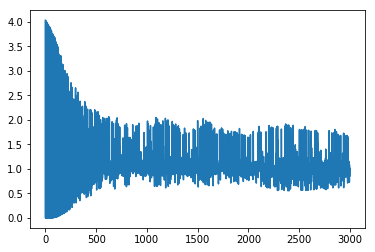

In [20]:

plt.plot(rec)
plt.show